# Clustering Significant Earthquakes with DBSCAN

## Overview

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a powerful unsupervised clustering algorithm that groups points based on density and identifies outliers in the dataset. Unlike other clustering methods, it does not require specifying the number of clusters in advance and can find clusters of arbitrary shapes.

## Objective

In this notebook, we will:
1. Load a dataset of significant earthquakes from `significant_earthquakes.csv`.
2. Perform basic preprocessing to prepare the data for clustering.
3. Apply DBSCAN to identify clusters of earthquake occurrences and detect noise (outliers).
4. Visualize the clustering results on a 2D scatter plot.



## Data preparation

Here, we upload the data and extract the latitude and longitude of earthquake locations to use as input for the clustering algorithm. These coordinates represent points in a 2D space for DBSCAN clustering.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.pyplot as plt

In [45]:
file_path = "/Users/ceciliaalberti/Documents/INDE_577/datasets/significant_earthquakes.csv"
df = pd.read_csv(file_path)
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2024-11-27T21:21:14.220Z,34.527833,-118.856167,8.86,1.33,ml,36.0,42.0,0.06963,0.24,...,2024-11-27T21:26:09.497Z,"14 km NNW of Piru, CA",earthquake,0.29,0.82,0.251,31.0,automatic,ci,ci
1,2024-11-27T21:20:16.503Z,63.002600,-148.148500,8.40,1.20,ml,NaN,NaN,NaN,1.03,...,2024-11-27T21:22:05.929Z,"59 km SE of Cantwell, Alaska",earthquake,NaN,0.30,NaN,NaN,automatic,ak,ak
2,2024-11-27T21:04:36.070Z,19.417000,-155.863159,8.39,2.13,md,23.0,219.0,0.15300,0.21,...,2024-11-27T21:06:37.650Z,"4 km S of Honaunau-Napoopoo, Hawaii",earthquake,0.90,0.67,0.320,6.0,automatic,hv,hv
3,2024-11-27T20:50:06.280Z,35.633000,-117.579500,8.03,1.19,ml,24.0,67.0,0.06898,0.14,...,2024-11-27T20:57:08.015Z,"9 km E of Ridgecrest, CA",earthquake,0.20,0.52,0.166,17.0,reviewed,ci,ci
4,2024-11-27T20:47:13.110Z,34.913500,-119.613000,8.40,0.98,ml,14.0,95.0,0.05794,0.18,...,2024-11-27T21:06:58.392Z,"25 km SW of Maricopa, CA",earthquake,0.40,0.81,0.058,7.0,reviewed,ci,ci


In [47]:
# Extract latitude and longitude for clustering
coordinates = df[['latitude', 'longitude']].to_numpy()

# Display the extracted coordinates
coordinates


array([[  34.5278333 , -118.8561667 ],
       [  63.0026    , -148.1485    ],
       [  19.41699982, -155.86315918],
       ...,
       [  33.4838333 , -116.4556667 ],
       [  49.3885    , -120.51333333],
       [  31.667     , -104.449     ]])

## DBScan algorithm


In [48]:
def euclidean_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    - point1: A numpy array representing the first point.
    - point2: A numpy array representing the second point.

    Returns:
    - A float representing the distance between the two points.
    """
    return np.sqrt(np.sum((point1 - point2) ** 2))


In [49]:
def find_neighbors(data, point_idx, eps):
    """
    Find all neighboring points within the radius `eps` of a given point.

    Parameters:
    - data: A numpy array of shape (n_points, n_features), the dataset.
    - point_idx: An integer, the index of the point for which to find neighbors.
    - eps: A float, the radius of the neighborhood.

    Returns:
    - A list of indices of points that are within the `eps` radius of the given point.
    """
    neighbors = []
    for idx, point in enumerate(data):
        if euclidean_distance(data[point_idx], point) <= eps:
            neighbors.append(idx)
    return neighbors



In [ ]:
def dbscan(data, eps, min_pts):
    """
    Perform Density-Based Spatial Clustering of Applications with Noise (DBSCAN).

    Parameters:
    - data: A numpy array of shape (n_points, n_features), the dataset.
    - eps: A float, the radius of the neighborhood for density estimation.
    - min_pts: An integer, the minimum number of points required to form a dense region.

    Returns:
    - labels: A list of integers where each entry corresponds to the cluster ID of a point.
              Noise points are labeled as -1.
    """
    n_points = len(data)
    labels = [-1] * n_points  # Initialize all points as noise (-1)
    cluster_id = 0  # Cluster counter

    for point_idx in range(n_points):
        # Skip if already labeled
        if labels[point_idx] != -1:
            continue
        
        # Find neighbors
        neighbors = find_neighbors(data, point_idx, eps)
        
        # Check if it's a core point
        if len(neighbors) < min_pts:
            labels[point_idx] = -1  # Mark as noise
            continue
        
        # Expand the cluster
        labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            
            # If neighbor is noise, include it in the cluster
            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id
            
            # Skip if already labeled
            if labels[neighbor_idx] != -1:
                i += 1
                continue
            
            # Add this point to the cluster
            labels[neighbor_idx] = cluster_id
            
            # Expand the neighbors list
            new_neighbors = find_neighbors(data, neighbor_idx, eps)
            if len(new_neighbors) >= min_pts:
                neighbors += new_neighbors
            
            i += 1
        
        # Move to the next cluster
        cluster_id += 1

    return labels


## Applying DBSCAN Algorithm

Using the chosen `eps` and `min_pts` values, we apply DBSCAN to cluster earthquake locations. Noise points will be identified as outliers.

In [50]:
# Compute pairwise distances
from scipy.spatial.distance import pdist, squareform
distance_matrix = squareform(pdist(coordinates))

distance_matrix


array([[ 0.        , 40.85159885, 39.97317577, ...,  2.61769675,
        14.95277954, 14.68845872],
       [40.85159885,  0.        , 44.26308292, ..., 43.31042911,
        30.80659273, 53.77328452],
       [39.97317577, 44.26308292,  0.        , ..., 41.84287595,
        46.34545297, 52.85336573],
       ...,
       [ 2.61769675, 43.31042911, 41.84287595, ...,  0.        ,
        16.41411226, 12.14334915],
       [14.95277954, 30.80659273, 46.34545297, ..., 16.41411226,
         0.        , 23.91891234],
       [14.68845872, 53.77328452, 52.85336573, ..., 12.14334915,
        23.91891234,  0.        ]])

In [51]:
# Set parameters
eps = 50  # Radius
min_pts = 5  # Minimum number of points in a neighborhood

# Apply DBSCAN
labels = dbscan(coordinates, eps, min_pts)

# Add the cluster labels back to the DataFrame
df['cluster'] = labels


## Visualizing Clusters

The results of the DBSCAN clustering are visualized using a scatter plot. Each cluster is represented with a unique color, and noise points are marked in black.

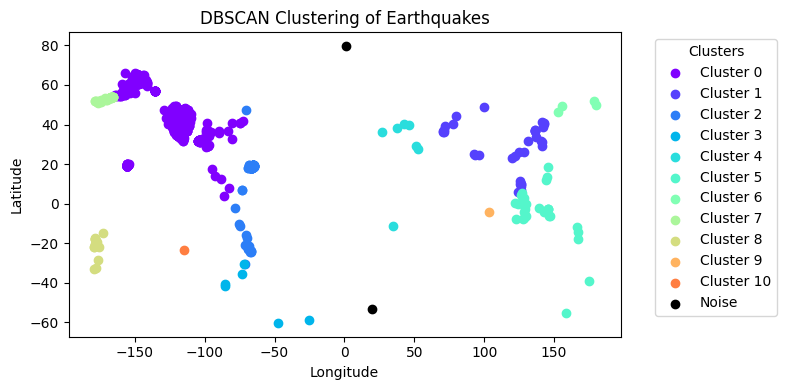

In [52]:
plt.figure(figsize=(8, 4))
for cluster_id in set(labels):
    if cluster_id == -1:  # Noise points
        color = 'k'
        label = 'Noise'
    else:
        color = plt.cm.rainbow(cluster_id / len(set(labels)))
        label = f'Cluster {cluster_id}'
    
    plt.scatter(
        df.loc[df['cluster'] == cluster_id, 'longitude'],
        df.loc[df['cluster'] == cluster_id, 'latitude'],
        c=[color],
        label=label
    )

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of Earthquakes')

# Move the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Clusters")

# Adjust layout to accommodate legend
plt.tight_layout()

# Show the plot
plt.show()


## Conclusions

- The DBSCAN algorithm successfully grouped earthquake locations into clusters based on proximity.
- Noise points, or  outliers, were identified where density was insufficient to form a cluster.


In [54]:
# Load a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

AttributeError: The geopandas.dataset has been deprecated and was removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

In [53]:
from geopandas import GeoDataFrame
from shapely.geometry import Point